# Two-dimensional liquids and solids

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from itertools import combinations

In [ ]:
colors = list(mcolors.TABLEAU_COLORS.keys()) + list(mcolors.BASE_COLORS.keys()) + list(mcolors.CSS4_COLORS.keys())

In [44]:
np.random.seed(4)

## Utility

In [ ]:
def distance_sq(p1, p2):
    dx = np.abs(p1[:, 0] - p2[:, 0])
    dx = np.min(np.vstack([dx, 1 - dx]), axis=0)

    dy = np.abs(p1[:, 1] - p2[:, 1])
    dy = np.min(np.vstack([dy, 1 - dy]), axis=0)
    
    return dx**2 + dy**2

In [ ]:
get_density = lambda balls, radius: balls*np.pi*radius*radius
get_radius = lambda balls, density: np.sqrt(density/(balls*np.pi))

In [ ]:
def show_conf(centers, radius, title=None):
    try:
        sampled_color = np.random.choice(colors, size=len(centers), replace=False)
    except:
        sampled_color = np.random.choice(colors, size=len(centers), replace=True)
    for (x,y),color in zip(centers, sampled_color):
        color = np.random.choice(colors)
        for dx in range(-1, 2):
            for dy in range(-1, 2):
                cir = plt.Circle((x+dx, y+dy), radius=radius, fc=color, ec="black")
                plt.gca().add_patch(cir)
    plt.axis("scaled")
    plt.title(title)
    plt.axis([0.0, 1.0]*2)

## Periodic Boundaries

In [7]:
def sample_disks_direct(balls, radius, pair_idx):
    coords = 0
    while True:
        coords = np.random.uniform(size=(balls, 2))
        if np.min(distance_sq(coords[(pair_idx[:,0])], coords[(pair_idx[:,1])])) >= (2*radius)**2:
            return coords

In [8]:
def direct_sampling(runs, balls, radius):
    pair_idx = np.array(list(combinations(range(0, balls),2)))
    return np.squeeze([sample_disks_direct(balls, radius, pair_idx) for x in range(int(runs))])

Packing Density is: 0.5654866776461628


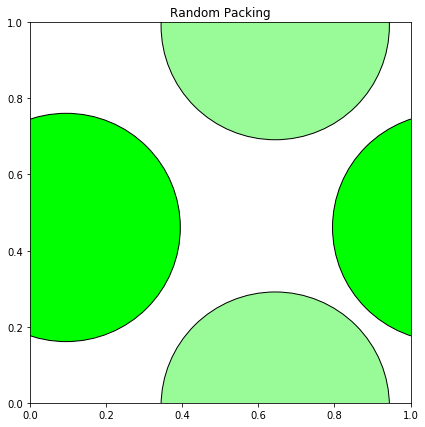

In [11]:
plt.rcParams["figure.figsize"] = 7, 7

runs = 1
balls = 2
radius = 0.3

config = direct_sampling(runs, balls, radius)
show_conf(config, radius, "Random Packing")

print("Packing Density is: {}".format(get_density(balls, radius)))

Packing Density is: 0.41814598219280147


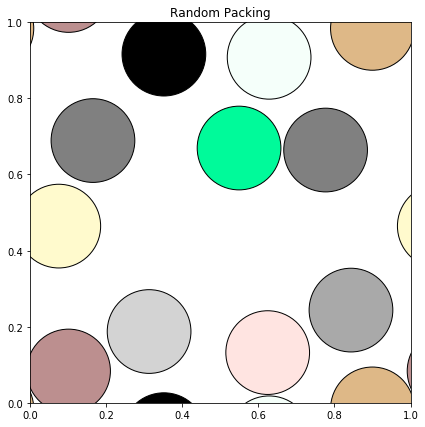

In [12]:
plt.rcParams["figure.figsize"] = 7, 7

runs = 1
balls = 11
radius = 0.11

config = direct_sampling(runs, balls, radius)
show_conf(config, radius, "Random Packing")

print("Packing Density is: {}".format(get_density(balls, radius)))

## MCMC Simulation with Periodic Conditions

In [ ]:
def sample_disks_markov(balls, radius, delta, pair_idx):
    coords = 0
    while True:
        coords = [np.random.uniform(size=(1,2))]
        while len(coords)<balls:
            coords.append( (coords[-1] + np.random.uniform(low=-delta, high=delta, size=(1,2)))%1 )
        coords = np.squeeze(np.array(coords))

        if np.min(distance_sq(coords[(pair_idx[:,0])], coords[(pair_idx[:,1])])) >= (2*radius)**2:
            return coords

In [ ]:
def markov_sampling(runs, balls, radius, delta):
    pair_idx = np.array(list(combinations(range(0, balls),2)))
    return np.squeeze([sample_disks_markov(balls, radius, delta, pair_idx) for x in range(int(runs))])

In [ ]:
plt.rcParams["figure.figsize"] = 7, 7

runs = 1
balls = 4
radius = 0.22
delta = 0.4

config = markov_sampling(runs, balls, radius, delta)
show_conf(config, radius, "Random Packing")

print("Packing Density is: {}".format(get_density(balls, radius)))

In [ ]:
plt.rcParams["figure.figsize"] = 7, 7

runs = 1
balls = 11
radius = 0.1
delta = 0.4

config = markov_sampling(runs, balls, radius, delta)
show_conf(config, radius, "Random Packing")

print("Packing Density is: {}".format(get_density(balls, radius)))

## Densities and Local Orientational Order

Let's check for configuration with maximum densities

### Uniform Square Packing

Max Packing Density is: 0.7853981633974483
Theoretical Maximum: 0.7853981633974483


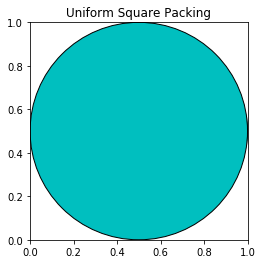

In [13]:
plt.rcParams["figure.figsize"] = 4, 4

balls = 1
radius = 0.5

config = [[0.5, 0.5]]
show_conf(config, radius, "Uniform Square Packing")
max_eta = get_density(balls, radius)

print("Max Packing Density is: {}".format(max_eta))

# Theortical Density is given by area_of_disk/area_of_square.
print("Theoretical Maximum: {}".format(np.pi/4)) 

In [14]:
balls_radius = {balls**2: np.sqrt(max_eta/(balls**2*np.pi)) for balls in range(1, 10+1)}

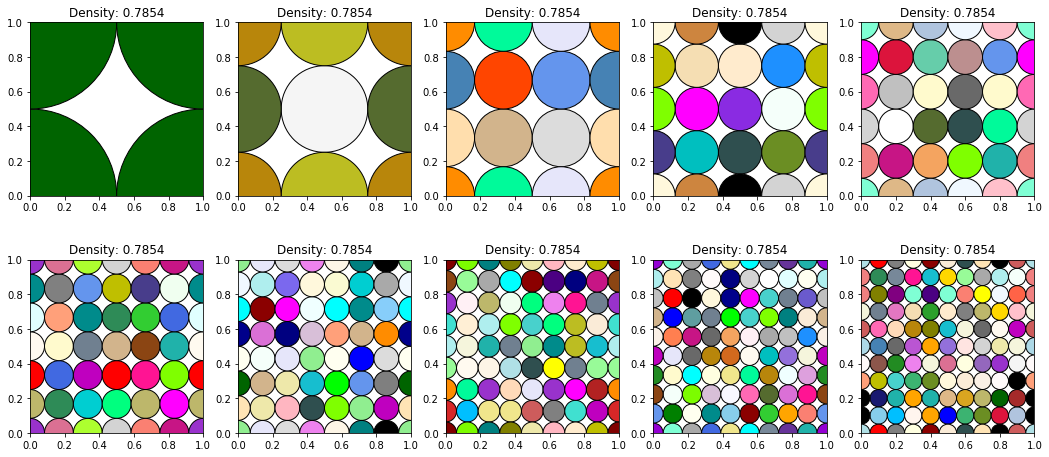

In [15]:
plt.rcParams["figure.figsize"] = 18, 8

for idx, balls in enumerate(balls_radius):
    delxy_1 = 1
    delxy_2 = 1

    L = [[delxy_1 + i * delxy_2, delxy_1 + j * delxy_2] for i in range(int(np.sqrt(balls))) for j in range(int(np.sqrt(balls)))]
    L = np.array(L)/np.max(L, axis=0)

    plt.subplot(2, 5, idx+1)
    show_conf(L, balls_radius[balls], "Density: {:.4f}".format(get_density(balls, balls_radius[balls])))
plt.show()

Here I'm rewrting the MCMC samping code so that it can genrte the samples for a given density. Also I've added the parameter to provide initial state as well which will use the uniform square packing as the default state.

In [16]:
def sample_disks_markov_square(balls, density, delta, pair_idx, initial_state=None):
    radius = get_radius(balls**2, density)
    coords = 0
    if initial_state == None:
        initial_state = np.array([[x,y] for x in range(balls) for y in range(balls)])/balls
    while True:
        coords = [random.choice(initial_state)]
        while len(coords)<balls**2:
            coords.append((random.choice(initial_state) + np.random.uniform(low=-delta, high=delta, size=(2)))%1) 
        coords = np.squeeze(np.array(coords))
    
        if np.min(distance_sq(coords[(pair_idx[:,0])], coords[(pair_idx[:,1])])) >= (2*radius)**2:
            return coords

In [17]:
def markov_sampling_square_discrete(runs, balls, density, delta):
    pair_idx = np.array(list(combinations(range(0, balls**2),2)))
    return np.squeeze([sample_disks_markov_square(balls, density, delta, pair_idx) for x in range(int(runs))])

In [18]:
def markov_sampling_square_sequential(runs, balls, density, delta):
    pair_idx = np.array(list(combinations(range(0, balls**2),2)))
    result = [sample_disks_markov_square(balls, density, delta, pair_idx)]
    for x in range(runs-1):
        result.append(sample_disks_markov_square(balls, density, delta, pair_idx, result[-1]))
    
    return np.squeeze(result)

In [ ]:
plt.rcParams["figure.figsize"] = 7, 7

runs = 1
balls_sqrt = 3
density = 0.5
delta = 0.4

config = markov_sampling_square_discrete(runs, balls_sqrt, density, delta)
show_conf(config, get_radius(balls, density))

In [ ]:
plt.rcParams["figure.figsize"] = 7, 7

runs = 1
balls_sqrt = 5
density = 0.2
delta = 0.3 * get_radius(balls_sqrt**2, density)

config = markov_sampling_square_discrete(runs, balls_sqrt, density, delta)
show_conf(config, get_radius(balls, density))

### Uniform Hexagonal Packing

In [ ]:
plt.rcParams["figure.figsize"] = 4, 4

balls = 7
radius = 0.166

config = np.apply_along_axis(lambda x:[np.sin((np.pi/180)*x), np.cos((np.pi/180)*x)] , 0, np.arange(0, 360, 60)).T
config = 0.5 + np.vstack([config, [0, 0]]) * 0.334

show_conf(config, radius, "Uniform Hexagonal Packing")

In [ ]:
# Here we have to determine the density theortically ie. 3*area_of_disk/area_of_hexagon

print("Theoretical Maximum: {}".format(np.sqrt(3)*np.pi/6)) 